# Preparing Alpha Factors and Features to Predict Stock Returns

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
stocks = pd.read_csv('./data/stocks.csv', index_col = 'ticker')

In [4]:
stocks

,marketcap,ipoyear,sector
ticker,,,
A,1.960000e+10,1999.0,capital_goods
AAL,1.767000e+10,NaN,transportation
AAMC,1.104900e+08,NaN,finance
AAN,3.200000e+09,NaN,technology
AAOI,9.000500e+08,2013.0,technology
...,...,...,...
ZIXI,2.944800e+08,NaN,technology
ZNGA,3.550000e+09,2011.0,technology
ZOES,1.974000e+08,2014.0,consumer_services


In [5]:
prices = pd.read_csv('./data/prices.csv', parse_dates = ['date'], index_col = ['ticker', 'date'])

In [6]:
prices

open      close        low       high    volume
ticker date                                                            
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500
...                      ...        ...        ...        ...       ...
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040

[2904233 rows x 5 columns]

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   close   float64
 2   low     float64
 3   high    float64
 4   volume  float64
dtypes: float64(5)
memory usage: 122.0+ MB


### Compute Rolling Average Dollar Volume

We will use a 21-day rolling average of the (adjusted) dollar volume traded to select the most liquid stocks for our model. Limiting the number of stocks also has the benefit of reducing training and backtesting time; excluding stocks with low dollar volumes can also reduce the noise of price data.

The computation requires us to multiply the daily close price wth the corresponding volume and then apply a rolling mean to each ticker using `.groupby()`, as follows:

In [8]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis = 1)

In [9]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  
ticker date                       
A      2013-01-02  181430.981611  
       2013-01-03  119142.939438  
       2013-01-04  135882.822089  
       2013-01-07   75273.116328  
       2013-01-08   81066.830411  
...                          ...  
ZUMZ   2017-12-22    4495.598250  
       2017-12-26    4674.829350  
       2017-12-27    4807.923750  
       2017-12-28    3435.884000  
       2017-12-29    4623.983000  

[2904233 rows x 6 columns]

In [10]:
# Computes monthly (21 day) rolling average dollar volume
prices['dollar_vol_1m'] = (prices['dollar_vol'].groupby('ticker').rolling(window = 21).mean()).values

In [11]:
prices.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2904233 non-null  float64
 1   close          2904233 non-null  float64
 2   low            2904233 non-null  float64
 3   high           2904233 non-null  float64
 4   volume         2904233 non-null  float64
 5   dollar_vol     2904233 non-null  float64
 6   dollar_vol_1m  2857273 non-null  float64
dtypes: float64(7)
memory usage: 166.3+ MB


We then use this value to rank stocks for each date so that we can select, for example, the 100 most-traded stocks for a given date:

In [12]:
prices['dollar_vol_rank'] = (prices.groupby('date')['dollar_vol_1m']
                             .rank(ascending = False))

In [13]:
prices.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
dtypes: float64(8)
memory usage: 188.5+ MB


In [14]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank  
ticker date                                                       
A      2013-01-02  181430.981611            NaN              NaN  
       2013-01-03  119142.939438            NaN              NaN  
       2013-01-04  135882.822089            NaN              NaN  
       2013-01-07   75273.116328            NaN              NaN  
       2013-01-08   81066.830411            NaN              NaN  
...                          ...            ...              ...  
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  
       2017-12-26    4674.829350   11963.373076           1291.0  
       2017-12-27    4807.923750   11786.938512           1293.0  
       2017-12-28    3435.884000   11290.208650           1300.0  
       2017-12-29    4623.983000   10790.612631           1312.0  

[2904233 rows x 8 columns]

### Add some basic factors

#### Compute the Relative Strength Index

In [15]:
prices['rsi'] = prices.groupby(level = 'ticker')['close'].apply(RSI)

In [16]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  
ticker date                                                                  
A      2013-01-02  181430.981611            NaN              NaN        NaN  
       2013-01-03  119142.939438            NaN              NaN        NaN  
       2013-01-04  135882.822089            NaN              NaN        NaN  
       2013-01-07   75273.116328            NaN              NaN        NaN  
       2013-01-08   81066.830411            NaN              NaN        NaN  
...                          ...            ...              ...        ...  
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094  
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097  
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727  
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082  
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469  

[2904233 rows x 9 columns]

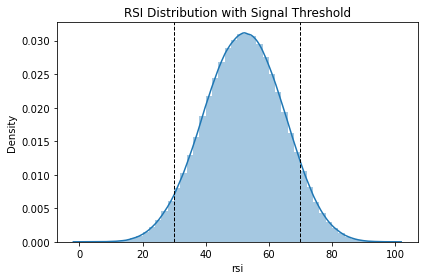

In [17]:
ax = sns.distplot(prices['rsi'].dropna())
ax.axvline(30, ls = '--', lw = 1, c = 'k')
ax.axvline(70, ls = '--', lw = 1, c = 'k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

## Compute Bollinger Bands

We compute Bollinger Bands. The TA-Lib `BBANDS` function returns three values so that we set up a function that returns a `DataFrame` with the higher and lower bands for use with `groupby()` and `apply()`

In [18]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod = 20)
    return pd.DataFrame({'bb_high' : high, 'bb_low' : low}, index = close.index)

In [19]:
prices = (prices.join(prices
                      .groupby(level = 'ticker')['close']
                      .apply(compute_bb)))

In [20]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                     bb_high     bb_low  
ticker date                              
A      2013-01-02        NaN        NaN  
       2013-01-03        NaN        NaN  
       2013-01-04        NaN        NaN  
       2013-01-07        NaN        NaN  
       2013-01-08        NaN        NaN  
...                      ...        ...  
ZUMZ   2017-12-22  22.086859  19.503141  
       2017-12-26  22.073133  19.781867  
       2017-12-27  22.063697  19.896303  
       2017-12-28  22.083536  19.911464  
       2017-12-29  21.972038  19.925462  

[2904233 rows x 11 columns]

We take the percentage difference between the stock price and upper lor lower Bollinger Band and take logs to compress the distribution. The goal is to reflect the current value, relative to the recent volatility trend:

In [21]:
prices['bb_high'] = prices['bb_high'].sub(prices['close']).div(prices['bb_high']).apply(np.log1p)

prices['bb_low'] = prices['close'].sub(prices['bb_low']).div(prices['close']).apply(np.log1p)

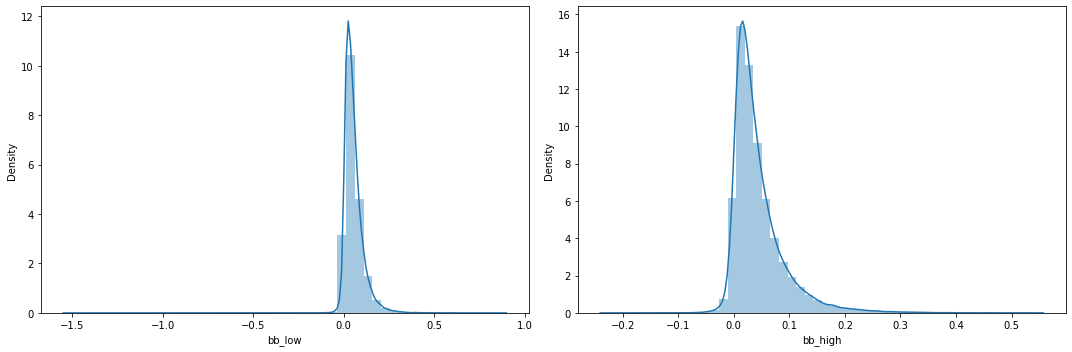

In [22]:
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

sns.distplot(prices.loc[prices['dollar_vol_rank'] < 100, 'bb_low'].dropna(), ax = axes[0])

sns.distplot(prices.loc[prices['dollar_vol_rank'] < 100, 'bb_high'].dropna(), ax = axes[1])

plt.tight_layout()

## Compute Average True Range

Next, we compute the average true range (ATR), which takes three inputs, namely, the high, low, and close prices. We standardize to make the metric more comparable across stocks.

In [23]:
def compute_atr(stock_data):
    df = ATR(stock_data['high'], stock_data['low'], stock_data['close'], timeperiod = 14)
    return df.sub(df.mean()).div(df.std())

In [24]:
prices['atr'] = (prices.groupby('ticker', group_keys = False)
                 .apply(compute_atr))

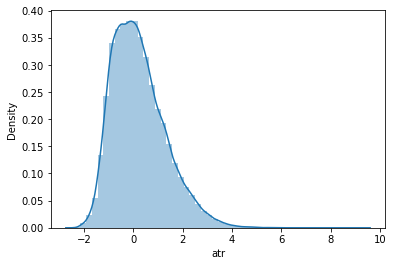

In [25]:
sns.distplot(prices[prices['dollar_vol_rank'] < 50].loc[:, 'atr'].dropna());

### Compute Moving Average Convergence / Divergence

In [26]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd)) / np.std(macd)

In [27]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys = False)['close']
                  .apply(compute_macd))

In [28]:
prices['macd'].describe(percentiles = [.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,826,749.0
mean            -0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

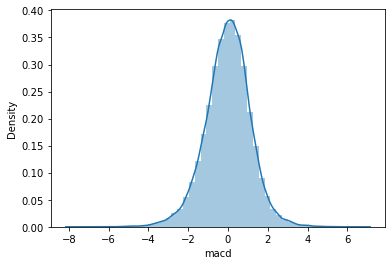

In [29]:
sns.distplot(prices[prices['dollar_vol_rank'] < 100]['macd'].dropna());

### Compute Lagged Returns

To capture the price trend for various historical lags, we compute the corresponding returns and transform the result into the daily geometric mean. We'll use lags for 1 day; 1, 2, and 3 months. We'll also winsorize the returns by clipping the values at the 0.01 and 99.99th percentile.

In [30]:
lags = [1, 5, 10, 21, 42, 63]

In [31]:
returns = prices.groupby(level = 'ticker')['close'].pct_change()
percentiles = [0.0001, 0.001, 0.01]
percentiles += [1 - p for p in percentiles]
returns.describe(percentiles = percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%
max,"10,280.40%"


### Winsorize Outliers

In [32]:
q = 0.0001

In [33]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level = 'ticker')['close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower = x.quantile(q),
                                                       upper = x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

In [34]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high    bb_low       atr      macd  return_1d  \
ticker date                                                            
A      2013-01-02       NaN       NaN       NaN       NaN        NaN   
       2013-01-03       NaN       NaN       NaN       NaN   0.003582   
       2013-01-04       NaN       NaN       NaN       NaN   0.019748   
       2013-01-07       NaN       NaN       NaN       NaN  -0.007233   
       2013-01-08       NaN       NaN       NaN       NaN  -0.007991   
...                     ...       ...       ...       ...        ...   
ZUMZ   2017-12-22  0.028426  0.086877 -0.419131  0.851425  -0.002326   
       2017-12-26  0.010058  0.090436 -0.450751  0.889373   0.018648   
       2017-12-27  0.040577  0.057586 -0.282948  0.832724  -0.032037   
       2017-12-28  0.039229  0.059005 -0.449763  0.784419   0.002364   
       2017-12-29  0.050887  0.042288 -0.515043  0.696842  -0.017689   

                   return_5d  return_10d  return_21d  return_42d  return_63d  
ticker date                                                                   
A      2013-01-02        NaN         NaN         NaN         NaN         NaN  
       2013-01-03        NaN         NaN         NaN         NaN         NaN  
       2013-01-04        NaN         NaN         NaN         NaN         NaN  
       2013-01-07        NaN         NaN         NaN         NaN         NaN  
       2013-01-08        NaN         NaN         NaN         NaN         NaN  
...                      ...         ...         ...         ...         ...  
ZUMZ   2017-12-22   0.013086    0.001173    0.006812    0.004653    0.004222  
       2017-12-26   0.005112    0.004215    0.006552    0.004759    0.004086  
       2017-12-27  -0.000472    0.002882    0.004617    0.003781    0.003757  
       2017-12-28   0.000000    0.004100    0.002540    0.003249    0.002958  
       2017-12-29  -0.006359    0.004050   -0.000057    0.003544    0.002674  

[2904233 rows x 19 columns]

### Shift Lagged Returns

We then shift the daily, (bi-)weekly, and monthly returns to use them as features for the current observations. In other words, in addition to the latest returns for these periods, we also use the prior five results. For example, we shift the weekly returns for the prior 5 weeks so that they align with the current observations and can be used to predict the current forward return:


In [35]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level = 'ticker')[f'return_{lag}d'].shift(t * lag))

In [36]:
prices.columns

Index(['open', 'close', 'low', 'high', 'volume', 'dollar_vol', 'dollar_vol_1m',
       'dollar_vol_rank', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd',
       'return_1d', 'return_5d', 'return_10d', 'return_21d', 'return_42d',
       'return_63d', 'return_1d_lag1', 'return_5d_lag1', 'return_10d_lag1',
       'return_21d_lag1', 'return_1d_lag2', 'return_5d_lag2',
       'return_10d_lag2', 'return_21d_lag2', 'return_1d_lag3',
       'return_5d_lag3', 'return_10d_lag3', 'return_21d_lag3',
       'return_1d_lag4', 'return_5d_lag4', 'return_10d_lag4',
       'return_21d_lag4', 'return_1d_lag5', 'return_5d_lag5',
       'return_10d_lag5', 'return_21d_lag5'],
      dtype='object')

In [37]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_10d_lag3  return_21d_lag3  \
ticker date                  ...                                     
A      2013-01-02       NaN  ...              NaN              NaN   
       2013-01-03       NaN  ...              NaN              NaN   
       2013-01-04       NaN  ...              NaN              NaN   
       2013-01-07       NaN  ...              NaN              NaN   
       2013-01-08       NaN  ...              NaN              NaN   
...                     ...  ...              ...              ...   
ZUMZ   2017-12-22  0.028426  ...         0.000553         0.014335   
       2017-12-26  0.010058  ...         0.002141         0.012572   
       2017-12-27  0.040577  ...         0.002479         0.010359   
       2017-12-28  0.039229  ...         0.001711         0.014717   
       2017-12-29  0.050887  ...         0.001407         0.014531   

                   return_1d_lag4  return_5d_lag4  return_10d_lag4  \
ticker date                                                          
A      2013-01-02             NaN             NaN              NaN   
       2013-01-03             NaN             NaN              NaN   
       2013-01-04             NaN             NaN              NaN   
       2013-01-07             NaN             NaN              NaN   
       2013-01-08             NaN             NaN              NaN   
...                           ...             ...              ...   
ZUMZ   2017-12-22        0.059701        0.008066        -0.001101   
       2017-12-26       -0.004695        0.003155         0.005860   
       2017-12-27        0.000000        0.007634         0.004570   
       2017-12-28        0.014151        0.015044         0.002624   
       2017-12-29       -0.002326        0.032259         0.003759   

                   return_21d_lag4  return_1d_lag5  return_5d_lag5  \
ticker date                                                          
A      2013-01-02              NaN             NaN        

### Compute Forward Returns

We will test predictions for various look ahead periods. The goal is to identiy the holding period that produces the best predictive accuracy, as measured by the `information coefficient (IC)`.

ML is about optimizing some predictive objective, we introduce some of the key metrics used to measure the performance of an alpha factor. __Alpha__ is just the average return in excess of a benchmark.

This leads to the __information ratio (IR)__, which measures the average excess return per unit of risk taken by dividing alpha by the tracking risk. When the benchmark is the risk- free rate, the IR corresponds to the well-known Sharpe ratio. The fundamental law of active management breaks the IR down into a combination of forecasting skill and a strategy's ability to effectively leverage these forecasting skills.

The goal of alpha factors is the accurate directional prediction of future returns. Hence, a natural performance measure is the correlation between an alpha factor's predictions and the forward returns of the target assets.

It is better to use the non-parametric __Spearman rank correlation coefficient__, which measures how well the relationship between two variables can be described using a monotonic function, as opposed to the Pearson correlation, which measures the strength of a
linear relationship.

An __IC of 0.05 or even 0.1__ allows for __significant outperformance__ if there are sufficient opportunities to apply this forecasting skill.

More specifially, we shift returns for time horizon $t$ back by $t$ days to use them as forward returns. For instance, we shift the 5-day return from $t_0$ to $t_5$ back by 5 days so that  this value becomes the model target for $t_0$. We can generate daily, (bi-) weekly, and monthly forward returns as follows:

In [38]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level = 'ticker')[f'return_{t}d'].shift(-t)

### Compute Price and Meta Data

In [39]:
prices = prices.join(stocks[['sector']])

In [40]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_21d_lag4  return_1d_lag5  \
ticker date                  ...                                    
A      2013-01-02       NaN  ...              NaN             NaN   
       2013-01-03       NaN  ...              NaN             NaN   
       2013-01-04       NaN  ...              NaN             NaN   
       2013-01-07       NaN  ...              NaN             NaN   
       2013-01-08       NaN  ...              NaN             NaN   
...                     ...  ...              ...             ...   
ZUMZ   2017-12-22  0.028426  ...        -0.000389        0.005000   
       2017-12-26  0.010058  ...         0.002061        0.059701   
       2017-12-27  0.040577  ...         0.002362       -0.004695   
       2017-12-28  0.039229  ...         0.002069        0.000000   
       2017-12-29  0.050887  ...         0.001112        0.014151   

                   return_5d_lag5  return_10d_lag5  return_21d_lag5  \
ticker date                                                           
A      2013-01-02             NaN              NaN              NaN   
       2013-01-03             NaN              NaN              NaN   
       2013-01-04             NaN              NaN              NaN   
       2013-01-07             NaN              NaN              NaN   
       2013-01-08             NaN              NaN              NaN   
...                           ...              ...              ...   
ZUMZ   2017-12-22        0.001647         0.003633         0.001177   
       2017-12-26        0.000000        -0.000856         0.001556   
       2017-12-27        0.010119        -0.005377         0.003478   
       2017-12-28        0.017985        -0.008980         0.001167   
       2017-12-29        0.007702        -0.012096         0.002110   

                   target_1d  target_5d  target_10d  target_21d  \
ticker date                                                       
A      2013-01-02   0.003582   0.006924    0.002759    0.003734 

### Dummy Encoding of Categorical Variables

We need to convert any categorical variable into a numeric format so that the linear regression can process it. For this purpose, we will use a dummy encoding variable that creates individual columns for each cateogry level and flags the presence of this level in the original categorical column with an entry of 1, and 0 otherwise. The pandas function `get_dummies()` automates dummy encoding. It detects and properly converts columns of type `objects`. If you need dummy variables for columns containing integers, for instance, you can identify them using the keyword `columns`: 

In [41]:
df = pd.DataFrame({'categories' : ['A', 'B', 'C']})

In [42]:
df

,categories
0,A
1,B
2,C


In [43]:
pd.get_dummies(df)

,categories_A,categories_B,categories_C
0,1,0,0
1,0,1,0
2,0,0,1


When converting the all categories into dummy variables and estimating the model with an intercept (as you typically would), you inadvertently create multicollinearity: the matrix now contains redundant information, no longer has full rank, and instead becomes singular.


It is simple to avoid this by removing one of the new indicator columns. The coefficient on the missing category level now will be captured by the intercept (which is always 1, including when every reminaing category dummy is 0).

Use the `drop_first`keyword to correct the dummy variables accordingly.

In [44]:
pd.get_dummies(df, drop_first = True)

,categories_B,categories_C
0,0,0
1,1,0
2,0,1


To capture seasonal effects and changing market conditions, we create time indicator variables for the year and month:

In [45]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [46]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_5d_lag5  return_10d_lag5  \
ticker date                  ...                                    
A      2013-01-02       NaN  ...             NaN              NaN   
       2013-01-03       NaN  ...             NaN              NaN   
       2013-01-04       NaN  ...             NaN              NaN   
       2013-01-07       NaN  ...             NaN              NaN   
       2013-01-08       NaN  ...             NaN              NaN   
...                     ...  ...             ...              ...   
ZUMZ   2017-12-22  0.028426  ...        0.001647         0.003633   
       2017-12-26  0.010058  ...        0.000000        -0.000856   
       2017-12-27  0.040577  ...        0.010119        -0.005377   
       2017-12-28  0.039229  ...        0.017985        -0.008980   
       2017-12-29  0.050887  ...        0.007702        -0.012096   

                   return_21d_lag5  target_1d  target_5d  target_10d  \
ticker date                                                            
A      2013-01-02              NaN   0.003582   0.006924    0.002759   
       2013-01-03              NaN   0.019748   0.007685    0.004294   
       2013-01-04              NaN  -0.007233   0.002646    0.002970   
       2013-01-07              NaN  -0.007991   0.004611    0.004807   
       2013-01-08              NaN   0.027008   0.004833    0.004844   
...                            ...        ...        ...         ...   
ZUMZ   2017-12-22         0.001177   0.018648        NaN         NaN   
       2017-12-26         0.001556  -0.032037        NaN         NaN   
       2017-12-27         0.003478   0.002364        NaN         NaN   
       2017-12-28         0.001167  -0.017689        NaN         NaN   
       2017-12-29         0.002110        NaN        NaN         NaN   

                   target_21d             sector  year  month  
ticker date                                                    
A      2013-01-02    0.003734      capital_goods  2013   

Then, we combine our price data with the sector information and create dummy variables for the time and sector categories.

In [47]:
pd.factorize(prices['sector'], sort = True)

(array([1, 1, 1, ..., 4, 4, 4], dtype=int64),
 Index(['basic_industries', 'capital_goods', 'consumer_durables',
        'consumer_non-durables', 'consumer_services', 'energy', 'finance',
        'health_care', 'miscellaneous', 'public_utilities', 'technology',
        'transportation'],
       dtype='object'))

In [48]:
pd.factorize(prices['sector'], sort = True)[0]

array([1, 1, 1, ..., 4, 4, 4], dtype=int64)

In [49]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_5d_lag5  return_10d_lag5  \
ticker date                  ...                                    
A      2013-01-02       NaN  ...             NaN              NaN   
       2013-01-03       NaN  ...             NaN              NaN   
       2013-01-04       NaN  ...             NaN              NaN   
       2013-01-07       NaN  ...             NaN              NaN   
       2013-01-08       NaN  ...             NaN              NaN   
...                     ...  ...             ...              ...   
ZUMZ   2017-12-22  0.028426  ...        0.001647         0.003633   
       2017-12-26  0.010058  ...        0.000000        -0.000856   
       2017-12-27  0.040577  ...        0.010119        -0.005377   
       2017-12-28  0.039229  ...        0.017985        -0.008980   
       2017-12-29  0.050887  ...        0.007702        -0.012096   

                   return_21d_lag5  target_1d  target_5d  target_10d  \
ticker date                                                            
A      2013-01-02              NaN   0.003582   0.006924    0.002759   
       2013-01-03              NaN   0.019748   0.007685    0.004294   
       2013-01-04              NaN  -0.007233   0.002646    0.002970   
       2013-01-07              NaN  -0.007991   0.004611    0.004807   
       2013-01-08              NaN   0.027008   0.004833    0.004844   
...                            ...        ...        ...         ...   
ZUMZ   2017-12-22         0.001177   0.018648        NaN         NaN   
       2017-12-26         0.001556  -0.032037        NaN         NaN   
       2017-12-27         0.003478   0.002364        NaN         NaN   
       2017-12-28         0.001167  -0.017689        NaN         NaN   
       2017-12-29         0.002110        NaN        NaN         NaN   

                   target_21d             sector  year  month  
ticker date                                                    
A      2013-01-02    0.003734      capital_goods  2013   

In [50]:
# Run this cell ONLY if you have enough space and processing power in your computer, since it it will create a very large csv file, and will take a considerable amount of time.

# prices.assign(sector = pd.factorize(prices['sector'], sort = True)[0]).to_csv('.../model_data_no_dummies.csv')

In [51]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_5d_lag5  return_10d_lag5  \
ticker date                  ...                                    
A      2013-01-02       NaN  ...             NaN              NaN   
       2013-01-03       NaN  ...             NaN              NaN   
       2013-01-04       NaN  ...             NaN              NaN   
       2013-01-07       NaN  ...             NaN              NaN   
       2013-01-08       NaN  ...             NaN              NaN   
...                     ...  ...             ...              ...   
ZUMZ   2017-12-22  0.028426  ...        0.001647         0.003633   
       2017-12-26  0.010058  ...        0.000000        -0.000856   
       2017-12-27  0.040577  ...        0.010119        -0.005377   
       2017-12-28  0.039229  ...        0.017985        -0.008980   
       2017-12-29  0.050887  ...        0.007702        -0.012096   

                   return_21d_lag5  target_1d  target_5d  target_10d  \
ticker date                                                            
A      2013-01-02              NaN   0.003582   0.006924    0.002759   
       2013-01-03              NaN   0.019748   0.007685    0.004294   
       2013-01-04              NaN  -0.007233   0.002646    0.002970   
       2013-01-07              NaN  -0.007991   0.004611    0.004807   
       2013-01-08              NaN   0.027008   0.004833    0.004844   
...                            ...        ...        ...         ...   
ZUMZ   2017-12-22         0.001177   0.018648        NaN         NaN   
       2017-12-26         0.001556  -0.032037        NaN         NaN   
       2017-12-27         0.003478   0.002364        NaN         NaN   
       2017-12-28         0.001167  -0.017689        NaN         NaN   
       2017-12-29         0.002110        NaN        NaN         NaN   

                   target_21d             sector  year  month  
ticker date                                                    
A      2013-01-02    0.003734      capital_goods  2013   

In [52]:
# pd.read_csv('model_data_no_dummies.csv', parse_dates = ['date'], index_col = ['ticker', 'date'])

In [53]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_5d_lag5  return_10d_lag5  \
ticker date                  ...                                    
A      2013-01-02       NaN  ...             NaN              NaN   
       2013-01-03       NaN  ...             NaN              NaN   
       2013-01-04       NaN  ...             NaN              NaN   
       2013-01-07       NaN  ...             NaN              NaN   
       2013-01-08       NaN  ...             NaN              NaN   
...                     ...  ...             ...              ...   
ZUMZ   2017-12-22  0.028426  ...        0.001647         0.003633   
       2017-12-26  0.010058  ...        0.000000        -0.000856   
       2017-12-27  0.040577  ...        0.010119        -0.005377   
       2017-12-28  0.039229  ...        0.017985        -0.008980   
       2017-12-29  0.050887  ...        0.007702        -0.012096   

                   return_21d_lag5  target_1d  target_5d  target_10d  \
ticker date                                                            
A      2013-01-02              NaN   0.003582   0.006924    0.002759   
       2013-01-03              NaN   0.019748   0.007685    0.004294   
       2013-01-04              NaN  -0.007233   0.002646    0.002970   
       2013-01-07              NaN  -0.007991   0.004611    0.004807   
       2013-01-08              NaN   0.027008   0.004833    0.004844   
...                            ...        ...        ...         ...   
ZUMZ   2017-12-22         0.001177   0.018648        NaN         NaN   
       2017-12-26         0.001556  -0.032037        NaN         NaN   
       2017-12-27         0.003478   0.002364        NaN         NaN   
       2017-12-28         0.001167  -0.017689        NaN         NaN   
       2017-12-29         0.002110        NaN        NaN         NaN   

                   target_21d             sector  year  month  
ticker date                                                    
A      2013-01-02    0.003734      capital_goods  2013   

In [54]:
prices = pd.get_dummies(prices,
                        columns = ['year', 'month', 'sector'],
                        prefix = ['year', 'month', ''],
                        prefix_sep = ['_', '_', ''],
                        drop_first = True)

In [55]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  consumer_durables  consumer_non-durables  \
ticker date                  ...                                             
A      2013-01-02       NaN  ...                  0                      0   
       2013-01-03       NaN  ...                  0                      0   
       2013-01-04       NaN  ...                  0                      0   
       2013-01-07       NaN  ...                  0                      0   
       2013-01-08       NaN  ...                  0                      0   
...                     ...  ...                ...                    ...   
ZUMZ   2017-12-22  0.028426  ...                  0                      0   
       2017-12-26  0.010058  ...                  0                      0   
       2017-12-27  0.040577  ...                  0                      0   
       2017-12-28  0.039229  ...                  0                      0   
       2017-12-29  0.050887  ...                  0                      0   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
A      2013-01-02                  0       0        0            0   
       2013-01-03                  0       0        0            0   
       2013-01-04                  0       0        0            0   
       2013-01-07                  0       0        0            0   
       2013-01-08                  0       0        0            0   
...                              ...     ...      ...          ...   
ZUMZ   2017-12-22                  1       0        0            0   
       2017-12-26                  1       0        0            0   
       2017-12-27                  1       0        0            0   
       2017-12-28                  1       0        0            0   
       2017-12-29                  1       0        0            0   

                   miscellaneous  public_utilities  technology  transportation  
ticker date  

In [56]:
prices.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   open                   2904233 non-null  float64
 1   close                  2904233 non-null  float64
 2   low                    2904233 non-null  float64
 3   high                   2904233 non-null  float64
 4   volume                 2904233 non-null  float64
 5   dollar_vol             2904233 non-null  float64
 6   dollar_vol_1m          2857273 non-null  float64
 7   dollar_vol_rank        2857273 non-null  float64
 8   rsi                    2871361 non-null  float64
 9   bb_high                2859618 non-null  float64
 10  bb_low                 2859585 non-null  float64
 11  atr                    2871361 non-null  float64
 12  macd                   2826749 non-null  float64
 13 

We obtain some 50 features as a result that we can now use with the various regression models discussed in the previous section.

### Store Model Data

In [57]:
# Run this cell ONLY if you have enough space and processing power in your computer, since it it will create a very large csv file, and will take a considerable amount of time.

# prices.to_csv('.../model_data.csv')

In [58]:
# pd.read_csv('model_data.csv', parse_dates = ['date'], index_col = ['ticker', 'date'])

### Explore Data

#### Plot factors

In [59]:
target = 'target_5d'
top100 = prices[prices['dollar_vol_rank'] < 100].copy()

#### RSI

In [60]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100['rsi'], bins = [0, 30, 70, 100])

In [61]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4209.0,0.001126,0.010457,-0.067138,-0.003606,0.001051,0.006156,0.061889
"(30, 70]",107244.0,0.000446,0.007711,-0.170571,-0.003054,0.000650,0.004246,0.075653
"(70, 100]",10634.0,0.000018,0.006354,-0.087857,-0.002818,0.000145,0.003121,0.058570


#### Bollinger Bands

-2.68% (0.00%)


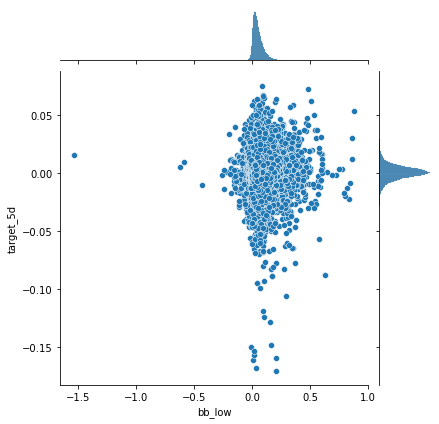

In [62]:
metric = 'bb_low'

j = sns.jointplot(x = metric, y = target, data = top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])

print(f'{r:,.2%} ({p:.2%})')

4.21% (0.00%)


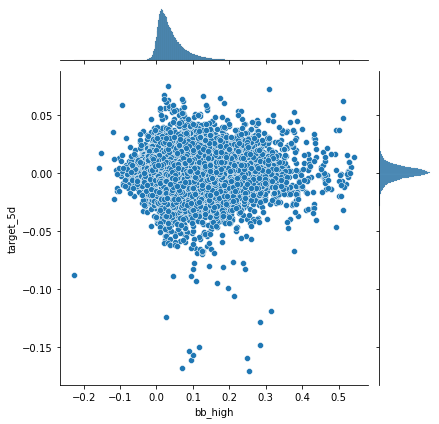

In [63]:
metric = 'bb_high'

j = sns.jointplot(x = metric, y = target, data = top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])

print(f'{r:,.2%} ({p:.2%})')

#### ATR

0.07% (80.08%)


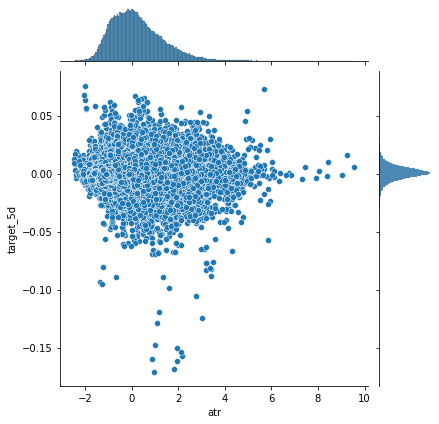

In [64]:
metric = 'atr'

j = sns.jointplot(x = metric, y = target, data = top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

#### MACD

-4.72% (0.00%)


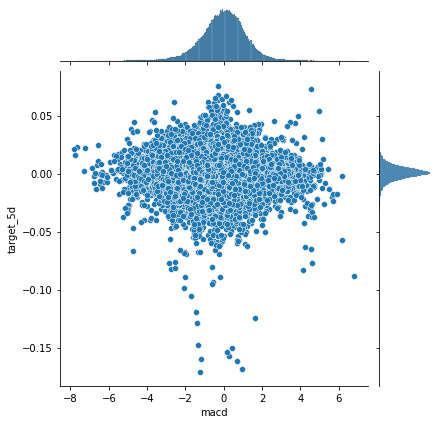

In [65]:
metric = 'macd'
j = sns.jointplot(x = metric, y = target, data = top100)

df = top100[[metric, target]].dropna()

r, p = spearmanr(df[metric], df[target])

print(f'{r:,.2%} ({p:.2%})')

In [66]:
df

macd  target_5d
ticker date                           
AAL    2013-02-20 -0.332963   0.001197
       2013-02-21 -0.437443   0.000896
       2013-02-22 -0.486683   0.000589
       2013-02-25 -0.597746   0.013166
       2013-02-26 -0.644682   0.011641
...                     ...        ...
ZTS    2014-11-28  2.806829  -0.004265
       2014-12-01  2.691178  -0.001220
       2014-12-02  2.615256  -0.004147
       2014-12-03  2.540352  -0.009585
       2014-12-04  2.329735  -0.005144

[120751 rows x 2 columns]

`End of File`